In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
train_size = 150
test_size = 10
return_day = 10
extreme_val = 0
full_size = train_size + test_size
# Error 1

In [4]:
data = pd.read_excel('USDCLP.xlsx', skiprows=4, index_col='Dates', parse_dates=True)
data.dropna(inplace=True)
data.columns = ['Open', 'High', 'Low', 'Close']
data = data['2004':] # before 2004 the data is not OHLC, but C
data['2018-01-08':'2018-01-13']

,Open,High,Low,Close
Dates,,,,
2018-01-08,606.37,608.47,604.58,605.31
2018-01-09,606.00,608.59,605.57,607.89
2018-01-10,607.66,610.70,606.23,609.32
2018-01-11,608.01,609.67,606.13,606.22
2018-01-12,603.17,605.81,602.86,603.18


In [5]:
new_data = data.resample('1W').pad()
new_data['Open'] = data['Open'].resample('1W').first()
new_data['Close'] = data['Close'].resample('1W').last()
new_data['High'] = data['High'].resample('1W').max()
new_data['Low'] = data['Low'].resample('1W').min()
new_data.dropna(inplace=True)
new_data.tail()

,Open,High,Low,Close
Dates,,,,
2018-01-07,612.19,612.45,601.80,605.78
2018-01-14,606.37,610.70,602.86,603.18
2018-01-21,599.58,608.82,599.31,608.21
2018-01-28,607.69,609.78,597.70,601.68
2018-02-04,603.65,607.37,596.31,597.03


In [6]:
data = new_data

In [7]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [8]:
features_to_delete = data.columns.tolist()

# ROC

In [9]:
for i in [2, 5, 10, 20]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

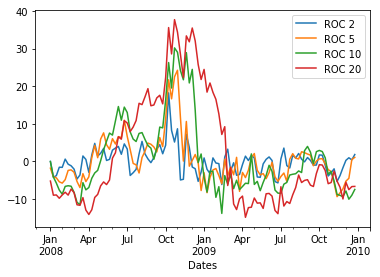

In [10]:
data['2008': '2009'][['ROC 2', 'ROC 5', 'ROC 10', 'ROC 20']].plot()

# Deviation from zero-lag exponential MA

In [11]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

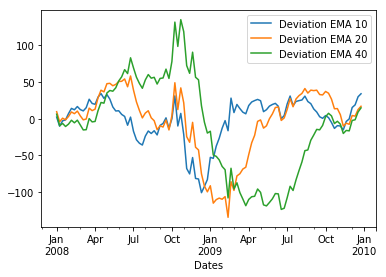

In [12]:
data['2008':'2009'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [13]:
for i, j, k in [(12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
#     data[f'MACD hist ({i}, {j}, {k})'] = macdhist

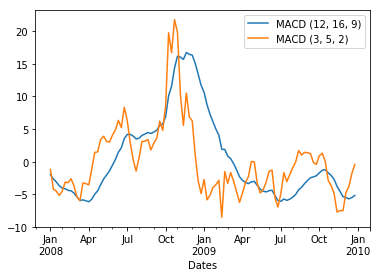

In [14]:
data['2008':'2009'][['MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [15]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

In [16]:
# data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [17]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

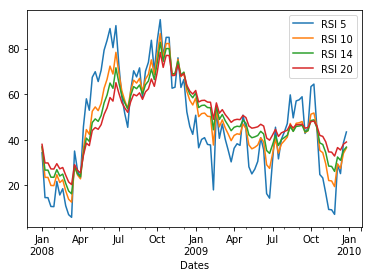

In [18]:
data['2008':'2009'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [19]:
for i, j in [(5, 10), (10, 20)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

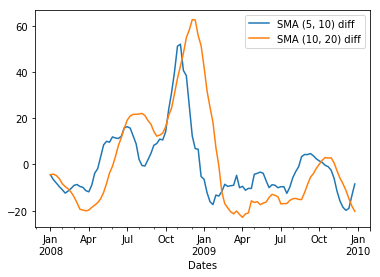

In [20]:
data['2008':'2009'][['SMA (5, 10) diff', 'SMA (10, 20) diff']].plot()

# ADX

In [21]:
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)

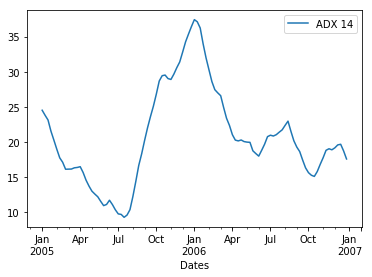

In [22]:
data['2005':'2006'][['ADX 14']].plot()

# CCI

In [23]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

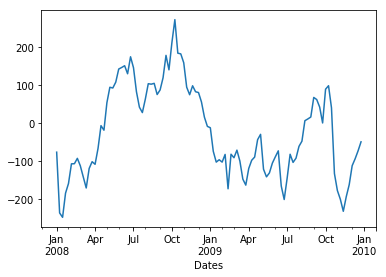

In [24]:
data['2008':'2009']['CCI 14'].plot()

# Y target value

In [25]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100

In [26]:
data.dropna(inplace=True)
close_hodl = data['Close'].copy()
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 2,ROC 5,ROC 10,ROC 20,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (12, 16, 9)","MACD (3, 5, 2)",RSI 5,RSI 10,RSI 14,RSI 20,"SMA (5, 10) diff","SMA (10, 20) diff",ADX 14,CCI 14,Return
Dates,,,,,,,,,,,,,,,,,,
2004-10-03,-0.950430,-3.565731,-4.773533,-5.258621,-3.145266,-33.071905,-39.414000,-1.063577,-3.861377,19.825401,34.272946,41.114504,46.984882,-11.395,-6.1890,23.131563,-149.550770,-1.968732
2004-10-10,-2.877405,-4.189450,-7.175132,-7.218502,-1.318854,-33.379343,-46.271854,-1.860784,-4.879007,14.557762,29.792533,37.437672,44.189530,-12.000,-8.4765,23.788964,-163.745237,-3.726395
2004-10-17,0.719663,-1.345001,-5.045621,-3.670886,15.480028,-16.183691,-34.079324,-1.949907,-2.230049,42.969704,42.352674,45.334744,48.982102,-10.425,-10.5515,23.417572,-96.015734,-7.769382
2004-10-24,2.182123,-0.245801,-4.830767,-5.576237,18.242751,-11.263816,-34.076674,-1.982963,-0.983722,42.901381,42.320443,45.311144,48.965143,-7.635,-11.8440,22.543811,-59.526914,-8.706366
2004-10-31,0.813075,0.057059,-2.818463,-5.431433,22.253160,-2.310119,-29.563178,-1.790757,0.429008,52.368375,46.817456,48.214271,50.759614,-5.785,-11.8615,21.732462,-39.499532,-7.046843


### Scale X and construct y

In [27]:
def to_class(y_vec):
    pos = y_vec > 0
    neg = y_vec <= 0

    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [28]:
# Error 2
scaler = StandardScaler()
X_all = data.drop(['Return'], axis=1)
y_all = data['Return'].copy()
ret_all = data['Return']
y_all.head()

Dates
2004-10-03   -1.968732
2004-10-10   -3.726395
2004-10-17   -7.769382
2004-10-24   -8.706366
2004-10-31   -7.046843
Freq: W-SUN, Name: Return, dtype: float64

In [29]:
# Error 3
X_all = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns, index=X_all.index)
y_all = to_class(y_all)
y_all.head()

Dates
2004-10-03    Neg
2004-10-10    Neg
2004-10-17    Neg
2004-10-24    Neg
2004-10-31    Neg
Freq: W-SUN, Name: Return, dtype: object

# Train and test Random Forest

In [30]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[-test_size:]
    train_ret = ret.iloc[:train_size]
    test_ret = ret.iloc[-test_size:]
    print('Split result before upsampling: {} -> {} + {}'.format(len(X), len(X_train), len(X_test)))
    test_from_date, test_to_date = test_ret.index[0], test_ret.index[-1]
    print(f'Test period: from {test_from_date} to {test_to_date}')
    
    last_q4 = 50
    last_q8 = 25
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:]], ignore_index=True)
    train_ret = pd.concat([train_ret, train_ret[-last_q4:], train_ret[-last_q8:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, train_ret, test_ret

In [31]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [32]:
def calculate_returns(ret, y_pred, log=True):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    if log:
        print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
        y_pred_s = pd.Series(y_pred, index=ret.index)
        return ret_sum, pd.concat([ret[y_pred == 'Pos'], -1*ret[y_pred == 'Neg']]), y_pred_s
    return ret_sum

In [33]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [34]:
def train_and_test(X, y, ret):
    X_train, X_test, y_train, y_test, train_ret, test_ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, oob_score=True, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[#('pca', PCA(svd_solver='auto')),
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [100],
              'forest__max_depth': [3, None],
              'forest__max_features': ['sqrt', None],
              'forest__min_samples_split': [2,5],
              'forest__min_samples_leaf': [5,10,20],
#               'pca__n_components': [6,12]
             }
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring='accuracy',
                        iid=False,
                        cv=5)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum, trades, y_pred_s = calculate_returns(test_ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': X.index[-1],
        'best_params': best_params,
        'ret_sum': ret_sum,
        'trades': trades,
        'predictions': y_pred_s
    }
    test_params.append(param)

In [35]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    X_ = X_all.iloc[i:i+full_size]
    y_ = y_all.iloc[i:i+full_size]
    ret_ = ret_all.iloc[i:i+full_size]
    from_date, to_date = X_.index[0], X_.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(X_, y_, ret_)

From 2004-10-03 00:00:00 to 2007-10-21 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2007-08-19 00:00:00 to 2007-10-21 00:00:00
---
Distribution:
Neg    163
Pos     62
Name: Return, dtype: int64
---
Distribution:
Neg    10
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.80      0.89        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89        10

---
Confusion matrix
 [[8 2]
 [0 0]]
-0.8405038369685092 [long] + 21.375349592261536 [short] = 20.534845755293027
From 2004-12-12 00:00:00 to 2007-12-30 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2007-10-28 00:00:00 to 2007-12-30 00:00:00
---
Distribution:
Neg    166
Pos     59
Name: Return, dtype: int64
---
Distribution:
Neg    10
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57        10

---
Confusion matrix
 [[4 6]
 [0 0]]
-46.63405805781453 [long] + 19.393736718180108 [short] = -27.24032133963442
From 2005-02-20 00:00:00 to 2008-03-09 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2008-01-06 00:00:00 to 2008-03-09 00:00:00
---
Distribution:
Neg    183
Pos     42
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.70      1.00      0.82         7
        Pos       0.00      0.00      0.00         3

avg / total       0.49      0.70      0.58        10

---
Confusion matrix
 [[7 0]
 [3 0]]
0.0 [long] + 33.81954747311243 [short] = 33.81954747311243
From 2005-05-01 00:00:00 to 2008-05-18 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2008-03-16 00:00:00 to 2008-05-18 00:00:00
---
Distribution:
Neg    179
Pos     46
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.80      0.89        10

avg / total       1.00      0.80      0.89        10

---
Confusion matrix
 [[0 0]
 [2 8]]
85.64868288068435 [long] + -11.095670246703481 [short] = 74.55301263398087
From 2005-07-10 00:00:00 to 2008-07-27 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2008-05-25 00:00:00 to 2008-07-27 00:00:00
---
Distribution:
Neg    152
Pos     73
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.30      0.46        10

avg / total       1.00      0.30      0.46        10

---
Confusion matrix
 [[0 0]
 [7 3]]
24.049100709910842 [long] + -42.47585599391455 [short] = -18.426755284003708
From 2005-09-18 00:00:00 to 2008-10-05 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2008-08-03 00:00:00 to 2008-10-05 00:00:00
---
Distribution:
Neg    123
Pos    102
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        10

---
Confusion matrix
 [[10]]
238.47728012352502 [long] + 0.0 [short] = 238.47728012352502
From 2005-11-27 00:00:00 to 2008-12-14 00:00:00
Split result before upsampling: 160 ->

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         9
        Pos       0.10      1.00      0.18         1

avg / total       0.01      0.10      0.02        10

---
Confusion matrix
 [[0 9]
 [0 1]]
-50.82812140963442 [long] + 0.0 [short] = -50.82812140963442
From 2006-02-05 00:00:00 to 2009-02-22 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2008-12-21 00:00:00 to 2009-02-22 00:00:00
---
Distribution:
Neg    117
Pos    108
Name: Return, dtype: int64
---
Distribution:
Neg    9
Pos    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.44      0.62         9
        Pos       0.17      1.00      0.29         1

avg / total       0.92      0.50      0.58        10

---
Confusion matrix
 [[4 5]
 [0 1]]
-30.518408005560207 [long] + 22.08181748373574 [short] = -8.436590521824467
From 2006-04-16 00

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.10      0.18        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.10      0.18        10

---
Confusion matrix
 [[1 9]
 [0 0]]
-49.01014096395277 [long] + 8.584273475273562 [short] = -40.42586748867921
From 2006-06-25 00:00:00 to 2009-07-12 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2009-05-10 00:00:00 to 2009-07-12 00:00:00
---
Distribution:
Neg    154
Pos     71
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.70      1.00      0.82         7
        Pos       0.00      0.00      0.00         3

avg / total       0.49      0.70      0.58        10

---
Confusion matrix
 [[7 0]
 [3 0]]
0.0 [long] + 13.500929721065878 [short] = 13.500929721065878
From 2006-09-03 00:00:00 to 2009-09-20 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2009-07-19 00:00:00 to 2009-09-20 00:00:00
---
Distribution:
Neg    156
Pos     69
Name: Return, dtype: int64
---
Distribution:
Neg    6
Pos    4
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.75      1.00      0.86         6
        Pos       1.00      0.50      0.67         4

avg / total       0.85      0.80      0.78        10

---
Confusion matrix
 [[6 0]
 [2 2]]
5.368792373388742 [long] + 35.57951707555471 [short] = 40.948309448943455
From 2006-11-12 00:0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.80      1.00      0.89         8

avg / total       0.64      0.80      0.71        10

---
Confusion matrix
 [[0 2]
 [0 8]]
33.81363599933981 [long] + 0.0 [short] = 33.81363599933981
From 2007-04-01 00:00:00 to 2010-04-18 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2010-02-14 00:00:00 to 2010-04-18 00:00:00
---
Distribution:
Neg    142
Pos     83
Name: Return, dtype: int64
---
Distribution:
Pos    8
Neg    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.60      0.38      0.46         8

avg / total       0.48      0.30      0.37        10

---
Confusion matrix
 [[0 2]
 [5 3]]
-0.772376962835819 [long] + -19.496181086560085 [short] = -20.268558049395903
From 2007-06-10 00

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         8
        Pos       0.20      1.00      0.33         2

avg / total       0.04      0.20      0.07        10

---
Confusion matrix
 [[0 8]
 [0 2]]
-29.660327759784334 [long] + 0.0 [short] = -29.660327759784334
From 2007-08-19 00:00:00 to 2010-09-05 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2010-07-04 00:00:00 to 2010-09-05 00:00:00
---
Distribution:
Neg    124
Pos    101
Name: Return, dtype: int64
---
Distribution:
Neg    10
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        10

---
Confusion matrix
 [[10]]
0.0 [long] + 59.897598005557086 [short] = 59.897598005557086
From 2007-10-28 00:00:00 to 2010-11-14 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.70      0.82        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.70      0.82        10

---
Confusion matrix
 [[7 3]
 [0 0]]
-4.48778809015341 [long] + 15.505304111526609 [short] = 11.017516021373199
From 2008-05-25 00:00:00 to 2011-06-12 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2011-04-10 00:00:00 to 2011-06-12 00:00:00
---
Distribution:
Neg    152
Pos     73
Name: Return, dtype: int64
---
Distribution:
Neg    5
Pos    5
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      1.00      0.67         5
        Pos       0.00      0.00      0.00         5

avg / total       0.25      0.50      0.33        10

---
Confusion matrix
 [[5 0]
 [5 0]]
0.0 [long] + 2.8062279588755508 [short] = 2.8062279588755508
From 2008-08-03 00:00:00 to 2011-08-21 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2011-06-19 00:00:00 to 2011-08-21 00:00:00
---
Distribution:
Neg    154
Pos     71
Name: Return, dtype: int64
---
Distribution:
Pos    8
Neg    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.67      0.50      0.57         8

avg / total       0.53      0.40      0.46        10

---
Confusion matrix
 [[0 2]
 [4 4]]
22.759118152711487 [long] + -36.75677958394146 [short] = -13.997661431229972
From 2008-10-12 0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         4
        Pos       0.00      0.00      0.00         6

avg / total       0.16      0.40      0.23        10

---
Confusion matrix
 [[4 0]
 [6 0]]
0.0 [long] + -10.432040158410416 [short] = -10.432040158410416
From 2009-05-10 00:00:00 to 2012-05-27 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2012-03-25 00:00:00 to 2012-05-27 00:00:00
---
Distribution:
Neg    126
Pos     99
Name: Return, dtype: int64
---
Distribution:
Pos    8
Neg    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.29      1.00      0.44         2
        Pos       1.00      0.38      0.55         8

avg / total       0.86      0.50      0.53        10

---
Confusion matrix
 [[2 0]
 [5 3]]
5.07426754121294 [long] + -8.930075424033788 [short] = -3.855807882820848
From 2009-07-19 00

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         6
        Pos       0.00      0.00      0.00         4

avg / total       0.36      0.60      0.45        10

---
Confusion matrix
 [[6 0]
 [4 0]]
0.0 [long] + 2.0299927923137395 [short] = 2.0299927923137395
From 2010-04-25 00:00:00 to 2013-05-12 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2013-03-10 00:00:00 to 2013-05-12 00:00:00
---
Distribution:
Neg    141
Pos     84
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.10      0.18        10

avg / total       1.00      0.10      0.18        10

---
Confusion matrix
 [[0 0]
 [9 1]]
5.032519458364426 [long] + -54.1193758732937 [short] = -49.08685641492927
From 2010-07-04 00:00:00 to 2013-07-21 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2013-05-19 00:00:00 to 2013-07-21 00:00:00
---
Distribution:
Neg    127
Pos     98
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         4
        Pos       0.00      0.00      0.00         6

avg / total       0.16      0.40      0.23        10

---
Confusion matrix
 [[4 0]
 [6 0]]
0.0 [long] + -14.786899863954282 [short] = -14.786899863954282
From 2010-09-12 00:00:00 to 2013-09-29 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2013-07-28 00:00:00 to 2013-09-29 00:00:00
---
Distribution:
Pos    114
Neg    111
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         4
        Pos       0.00      0.00      0.00         6

avg / total       0.16      0.40      0.23        10

---
Confusion matrix
 [[4 0]
 [6 0]]
0.0 [long] + -12.359111037372106 [short] = -12.359111037372106
From 2010-11-21 00:00:00 to 2013-12-08 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2013-10-06 00:00:00 to 2013-12-08 00:00:00
---
Distribution:
Pos    116
Neg    109
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.70      0.82        10

avg / total       1.00      0.70      0.82        10

---
Confusion matrix
 [[0 0]
 [3 7]]
31.985355405911275 [long] + -18.07406109869676 [short] = 13.911294307214515
From 2011-01-30 00:00:00 to 2014-02-16 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2013-12-15 00:00:00 to 2014-02-16 00:00:00
---
Distribution:
Pos    131
Neg     94
Name: Return, dtype: int64
---
Distribution:
Pos    9
Neg    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.25      1.00      0.40         1
        Pos       1.00      0.67      0.80         9

avg / total       0.93      0.70      0.76        10

---
Confusion matrix
 [[1 0]
 [3 6]]
34.25551212246647 [long] + -2.6866173409218264 [short] = 31.568894781544643
Fro

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         7
        Pos       0.30      1.00      0.46         3

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[0 7]
 [0 3]]
-8.834960955206173 [long] + 0.0 [short] = -8.834960955206173
From 2011-06-19 00:00:00 to 2014-07-06 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2014-05-04 00:00:00 to 2014-07-06 00:00:00
---
Distribution:
Pos    136
Neg     89
Name: Return, dtype: int64
---
Distribution:
Pos    9
Neg    1
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
        Pos       0.90      1.00      0.95         9

avg / total       0.81      0.90      0.85        10

---
Confusion matrix
 [[0 1]
 [0 9]]
40.81679287098581 [long] + 0.0 [short] = 40.81679287098581
From 2011-08-28 00:00:00 to 2014-09-14 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2014-07-13 00:00:00 to 2014-09-14 00:00:00
---
Distribution:
Pos    139
Neg     86
Name: Return, dtype: int64
---
Distribution:
Pos    9
Neg    1
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
        Pos       0.90      1.00      0.95         9

avg / total       0.81      0.90      0.85        10

---
Confusion matrix
 [[0 1]
 [0 9]]
26.465633203827842 [long] + 0.0 [short] = 26.465633203827842
From 2011-11-06 00:00:00 to 2014-11-23 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2014-09-21 00:00:00 to 2014-11-23 00:00:00
---
Distribution:
Pos    148
Neg     77
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.40      0.57        10

avg / total       1.00      0.40      0.57        10

---
Confusion matrix
 [[0 0]
 [6 4]]
24.9427962056336 [long] + -19.82342120752909 [short] = 5.119374998104508
From 2012-01-15 00:00:00 to 2015-02-01 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2014-11-30 00:00:00 to 2015-02-01 00:00:00
---
Distribution:
Pos    161
Neg     64
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.25      0.40         4
        Pos       0.67      1.00      0.80         6

avg / total       0.80      0.70      0.64        10

---
Confusion matrix
 [[1 3]
 [0 6]]
12.713555415228285 [long] + 2.2890541306950563 [short] = 15.002609545923342
From 2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00        10

avg / total       0.00      0.00      0.00        10

---
Confusion matrix
 [[ 0  0]
 [10  0]]
0.0 [long] + -32.30013889764449 [short] = -32.30013889764449
From 2012-12-30 00:00:00 to 2016-01-17 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2015-11-15 00:00:00 to 2016-01-17 00:00:00
---
Distribution:
Pos    173
Neg     52
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.29      0.44         7
        Pos       0.38      1.00      0.55         3

avg / total       0.81      0.50      0.47        10

---
Confusion matrix
 [[2 5]
 [0 3]]
-7.3999894964245865 [long] + 14.049185728512747 [short] = 6.64919623208816
From 2013-03-10

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         7
        Pos       0.30      1.00      0.46         3

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[0 7]
 [0 3]]
-19.0156760147316 [long] + 0.0 [short] = -19.0156760147316
From 2013-07-28 00:00:00 to 2016-08-14 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2016-06-12 00:00:00 to 2016-08-14 00:00:00
---
Distribution:
Pos    138
Neg     87
Name: Return, dtype: int64
---
Distribution:
Pos    7
Neg    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.75      1.00      0.86         3
        Pos       1.00      0.86      0.92         7

avg / total       0.93      0.90      0.90        10

---
Confusion matrix
 [[3 0]
 [1 6]]
10.85124985205006 [long] + 4.782387227181372 [short] = 15.633637079231432
From 2013-10-06 00:00:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         8
        Pos       0.20      1.00      0.33         2

avg / total       0.04      0.20      0.07        10

---
Confusion matrix
 [[0 8]
 [0 2]]
-21.88783389182963 [long] + 0.0 [short] = -21.88783389182963
From 2014-02-23 00:00:00 to 2017-03-12 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2017-01-08 00:00:00 to 2017-03-12 00:00:00
---
Distribution:
Pos    128
Neg     97
Name: Return, dtype: int64
---
Distribution:
Pos    9
Neg    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         1
        Pos       1.00      0.56      0.71         9

avg / total       0.92      0.60      0.68        10

---
Confusion matrix
 [[1 0]
 [4 5]]
13.239013650163443 [long] + -1.3332397082694958 [short] = 11.905773941893948
From 2014-05-04 0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.70      0.82        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.70      0.82        10

---
Confusion matrix
 [[7 3]
 [0 0]]
-10.157755320851258 [long] + 32.06519823535001 [short] = 21.907442914498752
From 2014-09-21 00:00:00 to 2017-10-08 00:00:00
Split result before upsampling: 160 -> 150 + 10
Test period: from 2017-08-06 00:00:00 to 2017-10-08 00:00:00
---
Distribution:
Pos    121
Neg    104
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.75      0.86         4
        Pos       0.86      1.00      0.92         6

avg / total       0.91      0.90      0.90        10

---
Confusion matrix
 [[3 1]
 [0 6]]
10.249872629088664 [long] + 8.520811140724948 [short] = 18.770683769813612


In [36]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [37]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [38]:
params.sort_values('Sum of return', ascending=False)

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
2008-10-05,NaN,sqrt,10,5,100,238.477280,1.0
2015-06-21,3.0,None,10,5,100,78.291010,1.0
2008-05-18,NaN,None,10,5,100,74.553013,0.8
2010-09-05,NaN,sqrt,5,2,100,59.897598,1.0
2009-11-29,NaN,None,5,5,100,56.493402,0.8
2012-01-08,NaN,sqrt,5,2,100,42.847589,0.8
2009-09-20,NaN,None,5,5,100,40.948309,0.8
2014-07-06,NaN,sqrt,5,2,100,40.816793,0.9
2012-08-05,NaN,None,5,2,100,40.711558,1.0
2015-08-30,NaN,sqrt,5,2,100,35.362294,0.7


In [39]:
params.describe()

,forest__max_depth,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
count,4.0,53.000000,53.000000,53.0,53.000000,53.000000
mean,3.0,5.943396,3.754717,100.0,11.871548,0.573585
std,0.0,2.604841,1.492361,0.0,42.604733,0.258063
min,3.0,5.000000,2.000000,100.0,-50.828121,0.000000
25%,3.0,5.000000,2.000000,100.0,-10.432040,0.400000
50%,3.0,5.000000,5.000000,100.0,6.361511,0.600000
75%,3.0,5.000000,5.000000,100.0,26.465633,0.800000
max,3.0,20.000000,5.000000,100.0,238.477280,1.000000


In [40]:
params['Sum of return'].sum()

629.1920283291321

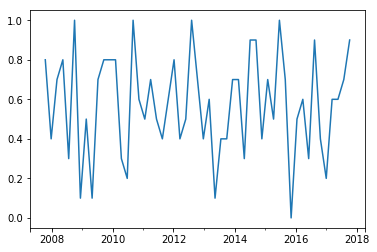

In [41]:
params['Accuracy'].plot()

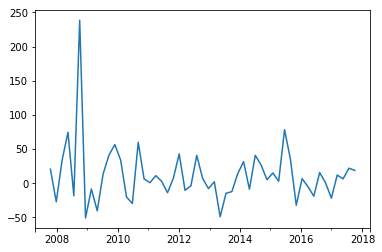

In [42]:
params['Sum of return'].plot()

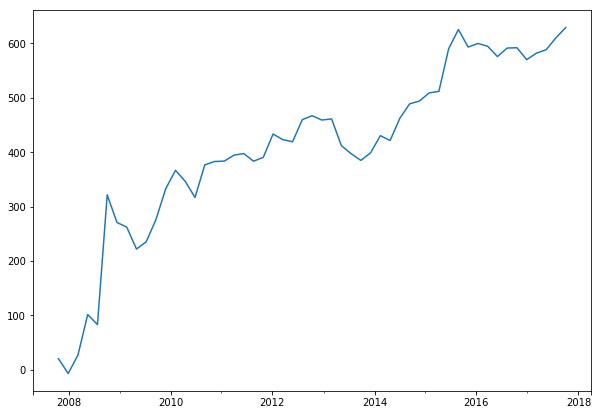

In [43]:
params['Sum of return'].cumsum().plot(figsize=(10,7))

#### Trades

In [44]:
all_trades = pd.concat([d['trades'] for d in test_params])

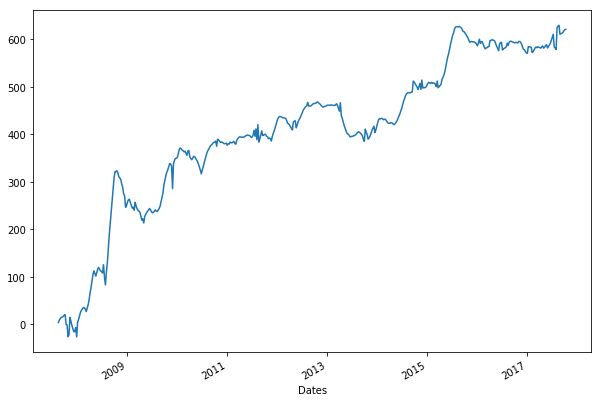

In [45]:
all_trades.cumsum().plot(figsize=(10,7))

#### Predictions

In [46]:
predictions = pd.concat([d['predictions'] for d in test_params])

In [47]:
predictions.value_counts()

Pos    267
Neg    263
dtype: int64

In [48]:
predictions.to_csv(f'pred/peso_prediction_not_ok_{train_size}_{test_size}_{return_day}.csv', header=True)

# Peso cumulative return VS strategy return

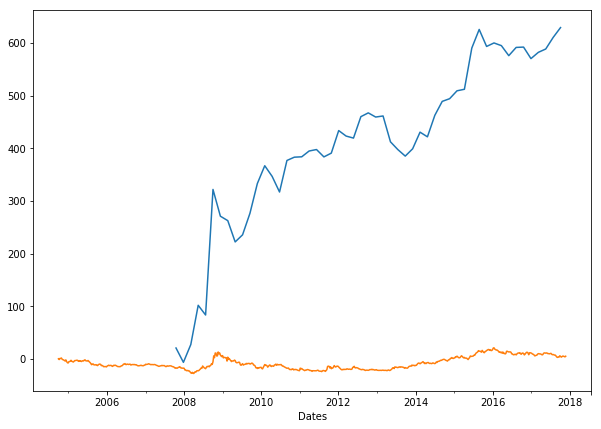

In [49]:
cumulative_ret = pd.Series((close_hodl/close_hodl.iloc[0]-1))*100
params['Sum of return'].cumsum().plot(figsize=(10,7))
cumulative_ret.plot(figsize=(10,7))

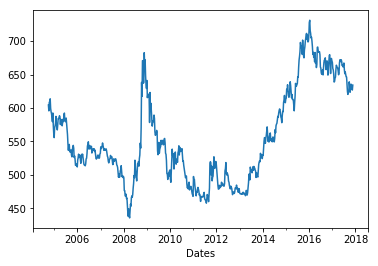

In [50]:
close_hodl.plot()